In [1]:
#!pip install gym-anytrading

In [2]:
#!pip install stable-baselines3

In [3]:
#pip install torch-tensorrt==1.2.0 --find-links https://github.com/pytorch/TensorRT/releases/expanded_assets/v1.2.0


In [4]:
#!pip install torch

In [1]:
import datetime
import requestspip
import time
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import stable_baselines3
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from finta import TA
from stable_baselines3.common.vec_env import DummyVecEnv
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
import gym_anytrading
import numba
import gym 
import math
from numba import cuda
import torch as th
from typing import Callable

ModuleNotFoundError: No module named 'tensorflow'

def get_binance_data_request_(ticker, interval='4h', limit=500, start='2018-01-01 00:00:00'):
  """
  interval: str tick interval - 4h/1h/1d ...
  """
  columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'qav','num_trades','taker_base_vol','taker_quote_vol', 'ignore']
  start = int(datetime.datetime.timestamp(pd.to_datetime(start))*1000)
  url = f'https://www.binance.com/api/v3/klines?symbol={ticker}&interval={interval}&limit={limit}&startTime={start}'
  data = pd.DataFrame(requests.get(url).json(), columns=columns, dtype=np.float)
  data.index = [pd.to_datetime(x, unit='ms').strftime('%Y-%m-%d %H:%M:%S') for x in data.open_time]
  usecols=['open', 'high', 'low', 'close', 'volume', 'qav','num_trades','taker_base_vol','taker_quote_vol']
  data = data[usecols]
  return data



In [2]:
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

NameError: name 'Callable' is not defined

In [3]:
now = str(datetime.datetime.now())[:19]
now

'2023-01-08 17:50:26'

In [8]:
cut=int(datetime.datetime.timestamp(pd.to_datetime(now))*1000)-30*24*60*60*1000
cut2=pd.to_datetime(cut, unit='ms').strftime('%Y-%m-%d %H:%M:%S')
cut2

'2022-12-08 17:04:41'

In [9]:
#data fo request:
ticker='BTCUSDT'
interval='15m'
period=365 #(in days)
period_finish=cut2

In [10]:
start=int(datetime.datetime.timestamp(pd.to_datetime(period_finish))*1000)-period*24*60*60*1000

In [11]:
start = pd.to_datetime(start, unit='ms').strftime('%Y-%m-%d %H:%M:%S') 
start

'2021-12-08 14:04:41'

In [12]:
count=period*24*60/15
req=count/1000
req

35.04

In [13]:
z=req//1
z

35.0

In [14]:
cut=int(datetime.datetime.timestamp(pd.to_datetime('2017-08-27 13:30:00'))*1000)-int(datetime.datetime.timestamp(pd.to_datetime('2017-08-17 04:00:00'))*1000)
cut=cut/(15*60*1000*1000)
cut

0.998

In [15]:
def get_binance_data_request_(ticker, interval='4h', limit=1000, start='2018-01-01 00:00:00'):
  """
  interval: str tick interval - 4h/1h/1d ...
  """
  columns = ['open_time','Open', 'High', 'Low', 'Close', 'Volume','Close_time', 'Qav','Num_trades','Taker_base_vol','Taker_quote_vol', 'ignore']
  start = int(datetime.datetime.timestamp(pd.to_datetime(start))*1000)
  url = f'https://www.binance.com/api/v3/klines?symbol={ticker}&interval={interval}&limit={limit}&startTime={start}'
  data = pd.DataFrame(requests.get(url).json(), columns=columns, dtype=float)
  open_time2 = [pd.to_datetime(x, unit='ms').strftime('%Y-%m-%d %H:%M:%S') for x in data.open_time]
  data.index = range(0,limit)
  data.insert(0,'open_time2',open_time2)

  usecols=['open_time2','Open', 'High', 'Low', 'Close', 'Volume', 'Qav','Num_trades','Taker_base_vol','Taker_quote_vol']
  data = data[usecols]
  return data



In [16]:
list=[]
z=get_binance_data_request_(ticker, interval, 1000,  start)
list.append(z)

In [17]:
list=[]
for i in range(0,int(req//1+1)):
    z=get_binance_data_request_(ticker, interval, 1000,  z['open_time2'].iloc[999])
    list.append(z)
    time.sleep(0.1)
a=pd.concat(list)
a.head(1002)

,open_time2,Open,High,Low,Close,Volume,Qav,Num_trades,Taker_base_vol,Taker_quote_vol
0,2021-12-18 18:00:00,46665.13,46767.27,46620.10,46698.18,201.55837,9.412180e+06,8616.0,110.62522,5.166556e+06
1,2021-12-18 18:15:00,46698.18,46777.84,46643.27,46692.00,163.50441,7.638529e+06,8162.0,87.48143,4.086767e+06
2,2021-12-18 18:30:00,46692.00,46752.23,46666.98,46728.78,178.09062,8.319927e+06,8374.0,104.36126,4.875335e+06
3,2021-12-18 18:45:00,46728.78,46763.93,46700.00,46726.37,117.58967,5.495868e+06,6647.0,59.62484,2.786725e+06
4,2021-12-18 19:00:00,46726.37,46774.44,46325.61,46439.86,477.94253,2.222300e+07,14869.0,207.65806,9.654559e+06
...,...,...,...,...,...,...,...,...,...,...
997,2021-12-29 03:15:00,48101.34,48111.88,47909.62,47939.99,377.72523,1.814301e+07,13239.0,155.37500,7.462225e+06
998,2021-12-29 03:30:00,47939.99,47995.43,47895.18,47961.85,215.64698,1.034079e+07,8127.0,108.48772,5.202085e+06
999,2021-12-29 03:45:00,47961.85,48037.30,47955.52,48001.01,224.07879,1.075328e+07,6789.0,124.78656,5.988219e+06
0,2021-12-29 00:45:00,47627.78,47775.52,47593.15,47770.12,228.23959,1.088072e+07,7752.0,113.12935,5.393824e+06


a=get_binance_data_request_(ticker, interval, 1000, start )

In [18]:
a=a.drop_duplicates()
a.head(1002)

,open_time2,Open,High,Low,Close,Volume,Qav,Num_trades,Taker_base_vol,Taker_quote_vol
0,2021-12-18 18:00:00,46665.13,46767.27,46620.10,46698.18,201.55837,9.412180e+06,8616.0,110.62522,5.166556e+06
1,2021-12-18 18:15:00,46698.18,46777.84,46643.27,46692.00,163.50441,7.638529e+06,8162.0,87.48143,4.086767e+06
2,2021-12-18 18:30:00,46692.00,46752.23,46666.98,46728.78,178.09062,8.319927e+06,8374.0,104.36126,4.875335e+06
3,2021-12-18 18:45:00,46728.78,46763.93,46700.00,46726.37,117.58967,5.495868e+06,6647.0,59.62484,2.786725e+06
4,2021-12-18 19:00:00,46726.37,46774.44,46325.61,46439.86,477.94253,2.222300e+07,14869.0,207.65806,9.654559e+06
...,...,...,...,...,...,...,...,...,...,...
997,2021-12-29 03:15:00,48101.34,48111.88,47909.62,47939.99,377.72523,1.814301e+07,13239.0,155.37500,7.462225e+06
998,2021-12-29 03:30:00,47939.99,47995.43,47895.18,47961.85,215.64698,1.034079e+07,8127.0,108.48772,5.202085e+06
999,2021-12-29 03:45:00,47961.85,48037.30,47955.52,48001.01,224.07879,1.075328e+07,6789.0,124.78656,5.988219e+06
13,2021-12-29 04:00:00,48001.01,48056.28,47930.59,47944.77,318.13619,1.527624e+07,8967.0,144.75164,6.949826e+06


In [19]:
a['open_time2'].iloc[999]

'2021-12-29 03:45:00'

In [20]:
a['open_time2']=pd.to_datetime(a['open_time2'])

In [21]:
a.sort_values('open_time2', ascending=True, inplace=True)

In [22]:
a.set_index('open_time2', inplace=True)

=============================================================================================================

In [23]:
env=gym.make('stocks-v0', df=a,frame_bound=(15,len(a)), window_size=10)

In [24]:
env.action_space

Discrete(2)

In [25]:
state=env.reset()
while True:
    action=env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    #done = truncated or terminated 
    if done:
        print('info', info)
        break

info {'total_reward': -47785100.00000297, 'total_profit': 1.7080241884548348, 'position': 1}


<function matplotlib.pyplot.show(close=None, block=None)>

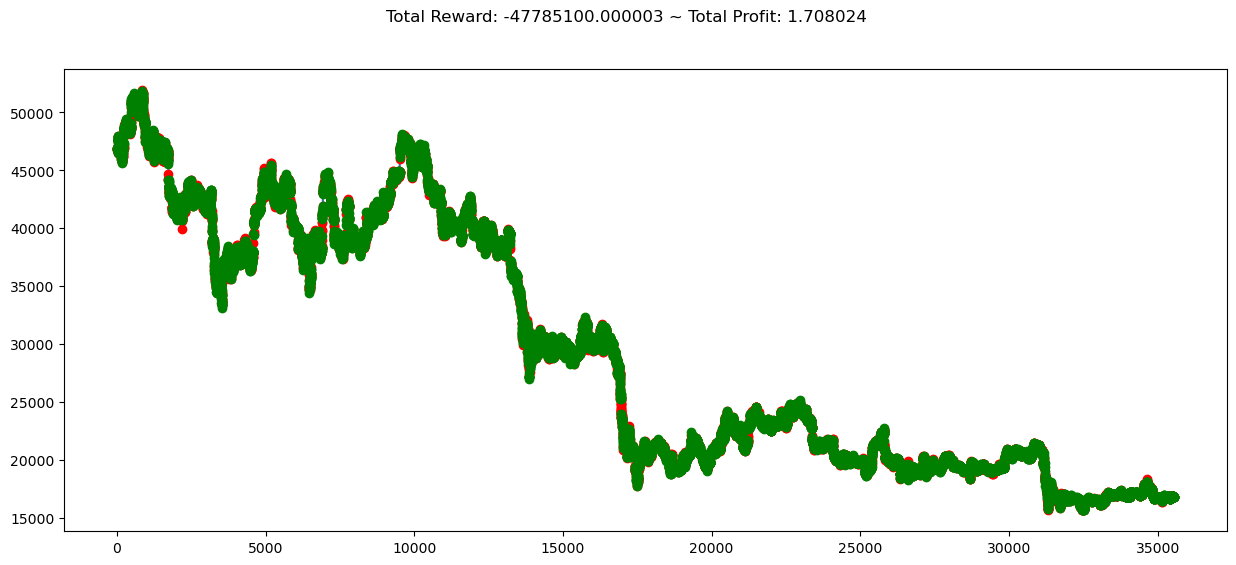

In [26]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show

In [27]:
a['SMA']=TA.SMA(a,12)
a['RSI']=TA.RSI(a)
a['OBV']=TA.OBV(a)
a.fillna(0, inplace=True)

In [28]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Close', 'Open', 'High', 'Low','SMA','RSI','OBV','Volume','Num_trades', 'Qav','Taker_base_vol','Taker_quote_vol']].to_numpy()[start:end]
    return prices, signal_features

In [29]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals

In [30]:
env2=MyCustomEnv(df=a,frame_bound=(15,1000), window_size=10)

In [31]:
env_maker=lambda: env2
env=DummyVecEnv([env_maker])
logdir='D:/my/@документы/GEEKBRAINS/Самостоятельная работа/'

policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=[dict(pi=[256, 256, 128], vf=[256, 256, 128])])
model = A2C("MlpPolicy", env, verbose=1,  learning_rate=linear_schedule(0.001),\
 n_steps=50, gamma=0.8, gae_lambda=1.0, ent_coef=0.2, vf_coef=0.2, \
tensorboard_log=logdir,  policy_kwargs=policy_kwargs, seed=50, device='cuda' )

https://stackoverflow.com/questions/66628280/gpu-underutilized-in-actor-critic-a2c-stable-baselines3-implementation

In [32]:
model = PPO("MlpPolicy", env, verbose=1,device="auto",tensorboard_log=logdir, learning_rate=linear_schedule(0.001))

Using cpu device


In [33]:
model.learn(total_timesteps=2000000)

Logging to D:/my/@документы/GEEKBRAINS/Самостоятельная работа/PPO_19
-----------------------------
| time/              |      |
|    fps             | 1466 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1199         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0076298863 |
|    clip_fraction        | 0.0492       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.687       |
|    explained_variance   | -2.36e-05    |
|    learning_rate        | 0.000999     |
|    loss                 | 3.86e+04     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00662     |
|    value_loss           | 7.64e

-----------------------------------------
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 13          |
|    time_elapsed         | 25          |
|    total_timesteps      | 26624       |
| train/                  |             |
|    approx_kl            | 0.005074727 |
|    clip_fraction        | 0.0371      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.599      |
|    explained_variance   | 0.0324      |
|    learning_rate        | 0.000988    |
|    loss                 | 5.71e+04    |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00534    |
|    value_loss           | 7.59e+04    |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1028       |
|    iterations           | 14         |
|    time_elapsed         | 27         |
|    total_timesteps      | 28672      

------------------------------------------
| time/                   |              |
|    fps                  | 1008         |
|    iterations           | 24           |
|    time_elapsed         | 48           |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0031515302 |
|    clip_fraction        | 0.0272       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.482       |
|    explained_variance   | 0.0608       |
|    learning_rate        | 0.000976     |
|    loss                 | 2.05e+04     |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00471     |
|    value_loss           | 9.37e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1001         |
|    iterations           | 25           |
|    time_elapsed         | 51           |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 987          |
|    iterations           | 35           |
|    time_elapsed         | 72           |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0057847667 |
|    clip_fraction        | 0.0506       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.417       |
|    explained_variance   | 0.111        |
|    learning_rate        | 0.000965     |
|    loss                 | 4.23e+04     |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00741     |
|    value_loss           | 8.45e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 987         |
|    iterations           | 36          |
|    time_elapsed         | 74          |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 995          |
|    iterations           | 46           |
|    time_elapsed         | 94           |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 0.0041703144 |
|    clip_fraction        | 0.0466       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.402       |
|    explained_variance   | 0.126        |
|    learning_rate        | 0.000954     |
|    loss                 | 5.14e+04     |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.0057      |
|    value_loss           | 7.7e+04      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 991          |
|    iterations           | 47           |
|    time_elapsed         | 97           |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 991          |
|    iterations           | 57           |
|    time_elapsed         | 117          |
|    total_timesteps      | 116736       |
| train/                  |              |
|    approx_kl            | 0.0028954146 |
|    clip_fraction        | 0.027        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.36        |
|    explained_variance   | 0.178        |
|    learning_rate        | 0.000943     |
|    loss                 | 2.64e+04     |
|    n_updates            | 560          |
|    policy_gradient_loss | -0.00376     |
|    value_loss           | 6.99e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 58           |
|    time_elapsed         | 119          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 991          |
|    iterations           | 68           |
|    time_elapsed         | 140          |
|    total_timesteps      | 139264       |
| train/                  |              |
|    approx_kl            | 0.0031112353 |
|    clip_fraction        | 0.0248       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.343       |
|    explained_variance   | 0.223        |
|    learning_rate        | 0.000931     |
|    loss                 | 2.44e+04     |
|    n_updates            | 670          |
|    policy_gradient_loss | -0.0044      |
|    value_loss           | 5.86e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 990         |
|    iterations           | 69          |
|    time_elapsed         | 142         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 79           |
|    time_elapsed         | 162          |
|    total_timesteps      | 161792       |
| train/                  |              |
|    approx_kl            | 0.0033975411 |
|    clip_fraction        | 0.0463       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.317       |
|    explained_variance   | 0.271        |
|    learning_rate        | 0.00092      |
|    loss                 | 2.83e+04     |
|    n_updates            | 780          |
|    policy_gradient_loss | -0.00576     |
|    value_loss           | 5.6e+04      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 80           |
|    time_elapsed         | 164          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 995          |
|    iterations           | 90           |
|    time_elapsed         | 185          |
|    total_timesteps      | 184320       |
| train/                  |              |
|    approx_kl            | 0.0027464149 |
|    clip_fraction        | 0.0222       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.296       |
|    explained_variance   | 0.298        |
|    learning_rate        | 0.000909     |
|    loss                 | 4.97e+04     |
|    n_updates            | 890          |
|    policy_gradient_loss | -0.00499     |
|    value_loss           | 6.98e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 995          |
|    iterations           | 91           |
|    time_elapsed         | 187          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 101          |
|    time_elapsed         | 208          |
|    total_timesteps      | 206848       |
| train/                  |              |
|    approx_kl            | 0.0038956704 |
|    clip_fraction        | 0.0277       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.296       |
|    explained_variance   | 0.348        |
|    learning_rate        | 0.000898     |
|    loss                 | 2.53e+04     |
|    n_updates            | 1000         |
|    policy_gradient_loss | -0.00299     |
|    value_loss           | 5.73e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 993         |
|    iterations           | 102         |
|    time_elapsed         | 210         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 112          |
|    time_elapsed         | 230          |
|    total_timesteps      | 229376       |
| train/                  |              |
|    approx_kl            | 0.0024296269 |
|    clip_fraction        | 0.0346       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.289       |
|    explained_variance   | 0.315        |
|    learning_rate        | 0.000886     |
|    loss                 | 3.72e+04     |
|    n_updates            | 1110         |
|    policy_gradient_loss | -0.00586     |
|    value_loss           | 7.69e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 993         |
|    iterations           | 113         |
|    time_elapsed         | 233         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 123          |
|    time_elapsed         | 253          |
|    total_timesteps      | 251904       |
| train/                  |              |
|    approx_kl            | 0.0041500544 |
|    clip_fraction        | 0.0348       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.275       |
|    explained_variance   | 0.394        |
|    learning_rate        | 0.000875     |
|    loss                 | 2.64e+04     |
|    n_updates            | 1220         |
|    policy_gradient_loss | -0.00363     |
|    value_loss           | 5.26e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 992         |
|    iterations           | 124         |
|    time_elapsed         | 255         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 134          |
|    time_elapsed         | 276          |
|    total_timesteps      | 274432       |
| train/                  |              |
|    approx_kl            | 0.0037111137 |
|    clip_fraction        | 0.043        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.276       |
|    explained_variance   | 0.402        |
|    learning_rate        | 0.000864     |
|    loss                 | 3.17e+04     |
|    n_updates            | 1330         |
|    policy_gradient_loss | -0.00478     |
|    value_loss           | 5.58e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 135          |
|    time_elapsed         | 278          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 145          |
|    time_elapsed         | 299          |
|    total_timesteps      | 296960       |
| train/                  |              |
|    approx_kl            | 0.0036586605 |
|    clip_fraction        | 0.0424       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.281       |
|    explained_variance   | 0.416        |
|    learning_rate        | 0.000853     |
|    loss                 | 3.33e+04     |
|    n_updates            | 1440         |
|    policy_gradient_loss | -0.00491     |
|    value_loss           | 5.33e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 991          |
|    iterations           | 146          |
|    time_elapsed         | 301          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 156          |
|    time_elapsed         | 322          |
|    total_timesteps      | 319488       |
| train/                  |              |
|    approx_kl            | 0.0050070835 |
|    clip_fraction        | 0.033        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.261       |
|    explained_variance   | 0.449        |
|    learning_rate        | 0.000841     |
|    loss                 | 3.27e+04     |
|    n_updates            | 1550         |
|    policy_gradient_loss | -0.00471     |
|    value_loss           | 5.31e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 157          |
|    time_elapsed         | 324          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 167          |
|    time_elapsed         | 344          |
|    total_timesteps      | 342016       |
| train/                  |              |
|    approx_kl            | 0.0027675054 |
|    clip_fraction        | 0.0356       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.263       |
|    explained_variance   | 0.444        |
|    learning_rate        | 0.00083      |
|    loss                 | 1.46e+04     |
|    n_updates            | 1660         |
|    policy_gradient_loss | -0.00467     |
|    value_loss           | 5.93e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 992         |
|    iterations           | 168         |
|    time_elapsed         | 346         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 178          |
|    time_elapsed         | 366          |
|    total_timesteps      | 364544       |
| train/                  |              |
|    approx_kl            | 0.0039332593 |
|    clip_fraction        | 0.0299       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.251       |
|    explained_variance   | 0.466        |
|    learning_rate        | 0.000819     |
|    loss                 | 1.35e+04     |
|    n_updates            | 1770         |
|    policy_gradient_loss | -0.00536     |
|    value_loss           | 5.59e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 994         |
|    iterations           | 179         |
|    time_elapsed         | 368         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 189          |
|    time_elapsed         | 389          |
|    total_timesteps      | 387072       |
| train/                  |              |
|    approx_kl            | 0.0026993812 |
|    clip_fraction        | 0.0357       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.252       |
|    explained_variance   | 0.476        |
|    learning_rate        | 0.000807     |
|    loss                 | 2.97e+04     |
|    n_updates            | 1880         |
|    policy_gradient_loss | -0.00454     |
|    value_loss           | 5.97e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 190          |
|    time_elapsed         | 391          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 995          |
|    iterations           | 200          |
|    time_elapsed         | 411          |
|    total_timesteps      | 409600       |
| train/                  |              |
|    approx_kl            | 0.0037342338 |
|    clip_fraction        | 0.0346       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.24        |
|    explained_variance   | 0.46         |
|    learning_rate        | 0.000796     |
|    loss                 | 4.44e+04     |
|    n_updates            | 1990         |
|    policy_gradient_loss | -0.00602     |
|    value_loss           | 7.12e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 995          |
|    iterations           | 201          |
|    time_elapsed         | 413          |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 994         |
|    iterations           | 211         |
|    time_elapsed         | 434         |
|    total_timesteps      | 432128      |
| train/                  |             |
|    approx_kl            | 0.003624651 |
|    clip_fraction        | 0.0367      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.237      |
|    explained_variance   | 0.516       |
|    learning_rate        | 0.000785    |
|    loss                 | 3.89e+04    |
|    n_updates            | 2100        |
|    policy_gradient_loss | -0.00569    |
|    value_loss           | 5.76e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 212          |
|    time_elapsed         | 436          |
|    total_timesteps      | 4

-----------------------------------------
| time/                   |             |
|    fps                  | 994         |
|    iterations           | 222         |
|    time_elapsed         | 457         |
|    total_timesteps      | 454656      |
| train/                  |             |
|    approx_kl            | 0.002430453 |
|    clip_fraction        | 0.025       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.233      |
|    explained_variance   | 0.508       |
|    learning_rate        | 0.000774    |
|    loss                 | 6.12e+04    |
|    n_updates            | 2210        |
|    policy_gradient_loss | -0.00427    |
|    value_loss           | 5.92e+04    |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 994         |
|    iterations           | 223         |
|    time_elapsed         | 459         |
|    total_timesteps      | 456704

------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 233          |
|    time_elapsed         | 479          |
|    total_timesteps      | 477184       |
| train/                  |              |
|    approx_kl            | 0.0032120254 |
|    clip_fraction        | 0.0316       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.231       |
|    explained_variance   | 0.52         |
|    learning_rate        | 0.000762     |
|    loss                 | 1.74e+04     |
|    n_updates            | 2320         |
|    policy_gradient_loss | -0.00533     |
|    value_loss           | 5.57e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 234          |
|    time_elapsed         | 482          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 244          |
|    time_elapsed         | 502          |
|    total_timesteps      | 499712       |
| train/                  |              |
|    approx_kl            | 0.0015484273 |
|    clip_fraction        | 0.0167       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.235       |
|    explained_variance   | 0.527        |
|    learning_rate        | 0.000751     |
|    loss                 | 1.47e+04     |
|    n_updates            | 2430         |
|    policy_gradient_loss | -0.00188     |
|    value_loss           | 6.23e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 245          |
|    time_elapsed         | 504          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 255          |
|    time_elapsed         | 525          |
|    total_timesteps      | 522240       |
| train/                  |              |
|    approx_kl            | 0.0040904414 |
|    clip_fraction        | 0.0498       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.232       |
|    explained_variance   | 0.526        |
|    learning_rate        | 0.00074      |
|    loss                 | 3.55e+04     |
|    n_updates            | 2540         |
|    policy_gradient_loss | -0.0059      |
|    value_loss           | 5.68e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 256          |
|    time_elapsed         | 527          |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 993         |
|    iterations           | 266         |
|    time_elapsed         | 548         |
|    total_timesteps      | 544768      |
| train/                  |             |
|    approx_kl            | 0.002538335 |
|    clip_fraction        | 0.0307      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.231      |
|    explained_variance   | 0.525       |
|    learning_rate        | 0.000729    |
|    loss                 | 3.55e+04    |
|    n_updates            | 2650        |
|    policy_gradient_loss | -0.00375    |
|    value_loss           | 7.18e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 267          |
|    time_elapsed         | 550          |
|    total_timesteps      | 5

------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 277          |
|    time_elapsed         | 571          |
|    total_timesteps      | 567296       |
| train/                  |              |
|    approx_kl            | 0.0057002166 |
|    clip_fraction        | 0.0377       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.229       |
|    explained_variance   | 0.561        |
|    learning_rate        | 0.000717     |
|    loss                 | 2.13e+04     |
|    n_updates            | 2760         |
|    policy_gradient_loss | -0.003       |
|    value_loss           | 4.85e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 278          |
|    time_elapsed         | 573          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 288          |
|    time_elapsed         | 594          |
|    total_timesteps      | 589824       |
| train/                  |              |
|    approx_kl            | 0.0027764412 |
|    clip_fraction        | 0.0267       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.227       |
|    explained_variance   | 0.544        |
|    learning_rate        | 0.000706     |
|    loss                 | 2.01e+04     |
|    n_updates            | 2870         |
|    policy_gradient_loss | -0.00429     |
|    value_loss           | 5.85e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 992         |
|    iterations           | 289         |
|    time_elapsed         | 596         |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 992         |
|    iterations           | 299         |
|    time_elapsed         | 617         |
|    total_timesteps      | 612352      |
| train/                  |             |
|    approx_kl            | 0.002186508 |
|    clip_fraction        | 0.0253      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.22       |
|    explained_variance   | 0.567       |
|    learning_rate        | 0.000695    |
|    loss                 | 2.34e+04    |
|    n_updates            | 2980        |
|    policy_gradient_loss | -0.00433    |
|    value_loss           | 6.43e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 300          |
|    time_elapsed         | 619          |
|    total_timesteps      | 6

------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 310          |
|    time_elapsed         | 639          |
|    total_timesteps      | 634880       |
| train/                  |              |
|    approx_kl            | 0.0028410254 |
|    clip_fraction        | 0.0259       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.225       |
|    explained_variance   | 0.547        |
|    learning_rate        | 0.000684     |
|    loss                 | 4.54e+04     |
|    n_updates            | 3090         |
|    policy_gradient_loss | -0.00481     |
|    value_loss           | 6.74e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 992         |
|    iterations           | 311         |
|    time_elapsed         | 641         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 321          |
|    time_elapsed         | 662          |
|    total_timesteps      | 657408       |
| train/                  |              |
|    approx_kl            | 0.0025755295 |
|    clip_fraction        | 0.0202       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.221       |
|    explained_variance   | 0.558        |
|    learning_rate        | 0.000672     |
|    loss                 | 2.26e+04     |
|    n_updates            | 3200         |
|    policy_gradient_loss | -0.00307     |
|    value_loss           | 7.24e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 322          |
|    time_elapsed         | 664          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 332          |
|    time_elapsed         | 684          |
|    total_timesteps      | 679936       |
| train/                  |              |
|    approx_kl            | 0.0030636857 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.216       |
|    explained_variance   | 0.565        |
|    learning_rate        | 0.000661     |
|    loss                 | 3.77e+04     |
|    n_updates            | 3310         |
|    policy_gradient_loss | -0.00407     |
|    value_loss           | 6.35e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 992         |
|    iterations           | 333         |
|    time_elapsed         | 687         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 992          |
|    iterations           | 343          |
|    time_elapsed         | 707          |
|    total_timesteps      | 702464       |
| train/                  |              |
|    approx_kl            | 0.0031248382 |
|    clip_fraction        | 0.032        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.209       |
|    explained_variance   | 0.561        |
|    learning_rate        | 0.00065      |
|    loss                 | 3.85e+04     |
|    n_updates            | 3420         |
|    policy_gradient_loss | -0.00596     |
|    value_loss           | 6.37e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 344          |
|    time_elapsed         | 709          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 993          |
|    iterations           | 354          |
|    time_elapsed         | 729          |
|    total_timesteps      | 724992       |
| train/                  |              |
|    approx_kl            | 0.0034561255 |
|    clip_fraction        | 0.0259       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.214       |
|    explained_variance   | 0.586        |
|    learning_rate        | 0.000639     |
|    loss                 | 3.52e+04     |
|    n_updates            | 3530         |
|    policy_gradient_loss | -0.0064      |
|    value_loss           | 5.82e+04     |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 993        |
|    iterations           | 355        |
|    time_elapsed         | 731        |
|    total_timesteps 

------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 365          |
|    time_elapsed         | 751          |
|    total_timesteps      | 747520       |
| train/                  |              |
|    approx_kl            | 0.0021555116 |
|    clip_fraction        | 0.0238       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.209       |
|    explained_variance   | 0.581        |
|    learning_rate        | 0.000627     |
|    loss                 | 3.74e+04     |
|    n_updates            | 3640         |
|    policy_gradient_loss | -0.00447     |
|    value_loss           | 6.25e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 366          |
|    time_elapsed         | 753          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 376          |
|    time_elapsed         | 774          |
|    total_timesteps      | 770048       |
| train/                  |              |
|    approx_kl            | 0.0028394375 |
|    clip_fraction        | 0.0321       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.205       |
|    explained_variance   | 0.577        |
|    learning_rate        | 0.000616     |
|    loss                 | 2.29e+04     |
|    n_updates            | 3750         |
|    policy_gradient_loss | -0.00482     |
|    value_loss           | 7.28e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 994          |
|    iterations           | 377          |
|    time_elapsed         | 776          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 995          |
|    iterations           | 387          |
|    time_elapsed         | 796          |
|    total_timesteps      | 792576       |
| train/                  |              |
|    approx_kl            | 0.0027312718 |
|    clip_fraction        | 0.0269       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.207       |
|    explained_variance   | 0.555        |
|    learning_rate        | 0.000605     |
|    loss                 | 4.07e+04     |
|    n_updates            | 3860         |
|    policy_gradient_loss | -0.00404     |
|    value_loss           | 6.46e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 995          |
|    iterations           | 388          |
|    time_elapsed         | 798          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 995          |
|    iterations           | 398          |
|    time_elapsed         | 818          |
|    total_timesteps      | 815104       |
| train/                  |              |
|    approx_kl            | 0.0026492544 |
|    clip_fraction        | 0.0239       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.196       |
|    explained_variance   | 0.599        |
|    learning_rate        | 0.000593     |
|    loss                 | 2.23e+04     |
|    n_updates            | 3970         |
|    policy_gradient_loss | -0.00389     |
|    value_loss           | 6.38e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 995          |
|    iterations           | 399          |
|    time_elapsed         | 820          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 409          |
|    time_elapsed         | 840          |
|    total_timesteps      | 837632       |
| train/                  |              |
|    approx_kl            | 0.0021434296 |
|    clip_fraction        | 0.0259       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.196       |
|    explained_variance   | 0.608        |
|    learning_rate        | 0.000582     |
|    loss                 | 1.94e+04     |
|    n_updates            | 4080         |
|    policy_gradient_loss | -0.00542     |
|    value_loss           | 5.86e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 410          |
|    time_elapsed         | 842          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 420          |
|    time_elapsed         | 863          |
|    total_timesteps      | 860160       |
| train/                  |              |
|    approx_kl            | 0.0021954025 |
|    clip_fraction        | 0.0261       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.193       |
|    explained_variance   | 0.624        |
|    learning_rate        | 0.000571     |
|    loss                 | 3.51e+04     |
|    n_updates            | 4190         |
|    policy_gradient_loss | -0.00423     |
|    value_loss           | 5.9e+04      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 421          |
|    time_elapsed         | 865          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 431          |
|    time_elapsed         | 885          |
|    total_timesteps      | 882688       |
| train/                  |              |
|    approx_kl            | 0.0025551436 |
|    clip_fraction        | 0.0226       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.187       |
|    explained_variance   | 0.616        |
|    learning_rate        | 0.00056      |
|    loss                 | 1.77e+04     |
|    n_updates            | 4300         |
|    policy_gradient_loss | -0.00447     |
|    value_loss           | 5.7e+04      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 996          |
|    iterations           | 432          |
|    time_elapsed         | 887          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 997          |
|    iterations           | 442          |
|    time_elapsed         | 907          |
|    total_timesteps      | 905216       |
| train/                  |              |
|    approx_kl            | 0.0017773629 |
|    clip_fraction        | 0.0195       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.187       |
|    explained_variance   | 0.623        |
|    learning_rate        | 0.000548     |
|    loss                 | 1.63e+04     |
|    n_updates            | 4410         |
|    policy_gradient_loss | -0.00379     |
|    value_loss           | 5.38e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 443         |
|    time_elapsed         | 909         |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 453         |
|    time_elapsed         | 929         |
|    total_timesteps      | 927744      |
| train/                  |             |
|    approx_kl            | 0.002993831 |
|    clip_fraction        | 0.0312      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.189      |
|    explained_variance   | 0.623       |
|    learning_rate        | 0.000537    |
|    loss                 | 2.65e+04    |
|    n_updates            | 4520        |
|    policy_gradient_loss | -0.0062     |
|    value_loss           | 5.78e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 997          |
|    iterations           | 454          |
|    time_elapsed         | 931          |
|    total_timesteps      | 9

------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 464          |
|    time_elapsed         | 951          |
|    total_timesteps      | 950272       |
| train/                  |              |
|    approx_kl            | 0.0023233034 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 0.612        |
|    learning_rate        | 0.000526     |
|    loss                 | 2.65e+04     |
|    n_updates            | 4630         |
|    policy_gradient_loss | -0.00433     |
|    value_loss           | 5.92e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 465          |
|    time_elapsed         | 953          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 475          |
|    time_elapsed         | 973          |
|    total_timesteps      | 972800       |
| train/                  |              |
|    approx_kl            | 0.0015234275 |
|    clip_fraction        | 0.0135       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.186       |
|    explained_variance   | 0.623        |
|    learning_rate        | 0.000515     |
|    loss                 | 3.52e+04     |
|    n_updates            | 4740         |
|    policy_gradient_loss | -0.0028      |
|    value_loss           | 6.49e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 476         |
|    time_elapsed         | 976         |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 486          |
|    time_elapsed         | 996          |
|    total_timesteps      | 995328       |
| train/                  |              |
|    approx_kl            | 0.0021326533 |
|    clip_fraction        | 0.0243       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.181       |
|    explained_variance   | 0.635        |
|    learning_rate        | 0.000503     |
|    loss                 | 1.11e+04     |
|    n_updates            | 4850         |
|    policy_gradient_loss | -0.00342     |
|    value_loss           | 5.7e+04      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 487          |
|    time_elapsed         | 998          |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 497          |
|    time_elapsed         | 1019         |
|    total_timesteps      | 1017856      |
| train/                  |              |
|    approx_kl            | 0.0025817333 |
|    clip_fraction        | 0.019        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.181       |
|    explained_variance   | 0.637        |
|    learning_rate        | 0.000492     |
|    loss                 | 1.1e+04      |
|    n_updates            | 4960         |
|    policy_gradient_loss | -0.00259     |
|    value_loss           | 5.6e+04      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 498          |
|    time_elapsed         | 1021         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 508          |
|    time_elapsed         | 1042         |
|    total_timesteps      | 1040384      |
| train/                  |              |
|    approx_kl            | 0.0016267854 |
|    clip_fraction        | 0.017        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 0.647        |
|    learning_rate        | 0.000481     |
|    loss                 | 3.34e+04     |
|    n_updates            | 5070         |
|    policy_gradient_loss | -0.00413     |
|    value_loss           | 5.73e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 509          |
|    time_elapsed         | 1044         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 519          |
|    time_elapsed         | 1064         |
|    total_timesteps      | 1062912      |
| train/                  |              |
|    approx_kl            | 0.0024590527 |
|    clip_fraction        | 0.0268       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 0.64         |
|    learning_rate        | 0.00047      |
|    loss                 | 1.98e+04     |
|    n_updates            | 5180         |
|    policy_gradient_loss | -0.00391     |
|    value_loss           | 5.42e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 520          |
|    time_elapsed         | 1066         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 530          |
|    time_elapsed         | 1087         |
|    total_timesteps      | 1085440      |
| train/                  |              |
|    approx_kl            | 0.0015458309 |
|    clip_fraction        | 0.0197       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.181       |
|    explained_variance   | 0.635        |
|    learning_rate        | 0.000458     |
|    loss                 | 2.14e+04     |
|    n_updates            | 5290         |
|    policy_gradient_loss | -0.00377     |
|    value_loss           | 6.77e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 531          |
|    time_elapsed         | 1089         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 541          |
|    time_elapsed         | 1109         |
|    total_timesteps      | 1107968      |
| train/                  |              |
|    approx_kl            | 0.0019576168 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.18        |
|    explained_variance   | 0.644        |
|    learning_rate        | 0.000447     |
|    loss                 | 4e+04        |
|    n_updates            | 5400         |
|    policy_gradient_loss | -0.00347     |
|    value_loss           | 5.69e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 542          |
|    time_elapsed         | 1111         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 998         |
|    iterations           | 552         |
|    time_elapsed         | 1132        |
|    total_timesteps      | 1130496     |
| train/                  |             |
|    approx_kl            | 0.003376954 |
|    clip_fraction        | 0.039       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.176      |
|    explained_variance   | 0.653       |
|    learning_rate        | 0.000436    |
|    loss                 | 6.19e+04    |
|    n_updates            | 5510        |
|    policy_gradient_loss | -0.00846    |
|    value_loss           | 5.23e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 998          |
|    iterations           | 553          |
|    time_elapsed         | 1134         |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 997          |
|    iterations           | 563          |
|    time_elapsed         | 1155         |
|    total_timesteps      | 1153024      |
| train/                  |              |
|    approx_kl            | 0.0025477111 |
|    clip_fraction        | 0.0235       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.174       |
|    explained_variance   | 0.648        |
|    learning_rate        | 0.000425     |
|    loss                 | 3.88e+04     |
|    n_updates            | 5620         |
|    policy_gradient_loss | -0.00541     |
|    value_loss           | 5.41e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 997          |
|    iterations           | 564          |
|    time_elapsed         | 1157         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 997          |
|    iterations           | 574          |
|    time_elapsed         | 1178         |
|    total_timesteps      | 1175552      |
| train/                  |              |
|    approx_kl            | 0.0020804275 |
|    clip_fraction        | 0.0185       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.173       |
|    explained_variance   | 0.65         |
|    learning_rate        | 0.000413     |
|    loss                 | 2.22e+04     |
|    n_updates            | 5730         |
|    policy_gradient_loss | -0.00423     |
|    value_loss           | 5.56e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 997         |
|    iterations           | 575         |
|    time_elapsed         | 1180        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 999         |
|    iterations           | 585         |
|    time_elapsed         | 1199        |
|    total_timesteps      | 1198080     |
| train/                  |             |
|    approx_kl            | 0.002067599 |
|    clip_fraction        | 0.0261      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.167      |
|    explained_variance   | 0.645       |
|    learning_rate        | 0.000402    |
|    loss                 | 2.64e+04    |
|    n_updates            | 5840        |
|    policy_gradient_loss | -0.0046     |
|    value_loss           | 6.02e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 999          |
|    iterations           | 586          |
|    time_elapsed         | 1201         |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 999          |
|    iterations           | 596          |
|    time_elapsed         | 1220         |
|    total_timesteps      | 1220608      |
| train/                  |              |
|    approx_kl            | 0.0015078535 |
|    clip_fraction        | 0.0207       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.174       |
|    explained_variance   | 0.652        |
|    learning_rate        | 0.000391     |
|    loss                 | 1.11e+04     |
|    n_updates            | 5950         |
|    policy_gradient_loss | -0.00443     |
|    value_loss           | 5.69e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 999          |
|    iterations           | 597          |
|    time_elapsed         | 1222         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1001         |
|    iterations           | 607          |
|    time_elapsed         | 1241         |
|    total_timesteps      | 1243136      |
| train/                  |              |
|    approx_kl            | 0.0013577722 |
|    clip_fraction        | 0.01         |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.171       |
|    explained_variance   | 0.661        |
|    learning_rate        | 0.000379     |
|    loss                 | 1.54e+04     |
|    n_updates            | 6060         |
|    policy_gradient_loss | -0.00291     |
|    value_loss           | 5.63e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1001         |
|    iterations           | 608          |
|    time_elapsed         | 1243         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1001         |
|    iterations           | 618          |
|    time_elapsed         | 1263         |
|    total_timesteps      | 1265664      |
| train/                  |              |
|    approx_kl            | 0.0020814317 |
|    clip_fraction        | 0.0182       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.169       |
|    explained_variance   | 0.644        |
|    learning_rate        | 0.000368     |
|    loss                 | 2.85e+04     |
|    n_updates            | 6170         |
|    policy_gradient_loss | -0.00436     |
|    value_loss           | 6.06e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1001         |
|    iterations           | 619          |
|    time_elapsed         | 1265         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1002         |
|    iterations           | 629          |
|    time_elapsed         | 1284         |
|    total_timesteps      | 1288192      |
| train/                  |              |
|    approx_kl            | 0.0016771001 |
|    clip_fraction        | 0.0137       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 0.647        |
|    learning_rate        | 0.000357     |
|    loss                 | 3.64e+04     |
|    n_updates            | 6280         |
|    policy_gradient_loss | -0.00475     |
|    value_loss           | 6.77e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1002         |
|    iterations           | 630          |
|    time_elapsed         | 1286         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1003         |
|    iterations           | 640          |
|    time_elapsed         | 1305         |
|    total_timesteps      | 1310720      |
| train/                  |              |
|    approx_kl            | 0.0024206697 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.17        |
|    explained_variance   | 0.665        |
|    learning_rate        | 0.000346     |
|    loss                 | 9.59e+03     |
|    n_updates            | 6390         |
|    policy_gradient_loss | -0.0056      |
|    value_loss           | 5.11e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1003         |
|    iterations           | 641          |
|    time_elapsed         | 1307         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 1005        |
|    iterations           | 651         |
|    time_elapsed         | 1326        |
|    total_timesteps      | 1333248     |
| train/                  |             |
|    approx_kl            | 0.002179535 |
|    clip_fraction        | 0.0268      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.167      |
|    explained_variance   | 0.66        |
|    learning_rate        | 0.000334    |
|    loss                 | 2.52e+04    |
|    n_updates            | 6500        |
|    policy_gradient_loss | -0.00359    |
|    value_loss           | 5.23e+04    |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1005       |
|    iterations           | 652        |
|    time_elapsed         | 1328       |
|    total_timesteps      | 1335296    

------------------------------------------
| time/                   |              |
|    fps                  | 1006         |
|    iterations           | 662          |
|    time_elapsed         | 1347         |
|    total_timesteps      | 1355776      |
| train/                  |              |
|    approx_kl            | 0.0025071993 |
|    clip_fraction        | 0.0153       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.169       |
|    explained_variance   | 0.66         |
|    learning_rate        | 0.000323     |
|    loss                 | 1.24e+04     |
|    n_updates            | 6610         |
|    policy_gradient_loss | -0.00318     |
|    value_loss           | 5.58e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1006         |
|    iterations           | 663          |
|    time_elapsed         | 1348         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 1007        |
|    iterations           | 673         |
|    time_elapsed         | 1367        |
|    total_timesteps      | 1378304     |
| train/                  |             |
|    approx_kl            | 0.003275385 |
|    clip_fraction        | 0.0173      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.17       |
|    explained_variance   | 0.665       |
|    learning_rate        | 0.000312    |
|    loss                 | 3.03e+04    |
|    n_updates            | 6720        |
|    policy_gradient_loss | -0.00334    |
|    value_loss           | 5.62e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1007         |
|    iterations           | 674          |
|    time_elapsed         | 1369         |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 1008         |
|    iterations           | 684          |
|    time_elapsed         | 1388         |
|    total_timesteps      | 1400832      |
| train/                  |              |
|    approx_kl            | 0.0013694698 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.166       |
|    explained_variance   | 0.659        |
|    learning_rate        | 0.000301     |
|    loss                 | 5.02e+04     |
|    n_updates            | 6830         |
|    policy_gradient_loss | -0.00558     |
|    value_loss           | 6.2e+04      |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1008         |
|    iterations           | 685          |
|    time_elapsed         | 1390         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1009         |
|    iterations           | 695          |
|    time_elapsed         | 1409         |
|    total_timesteps      | 1423360      |
| train/                  |              |
|    approx_kl            | 0.0019210142 |
|    clip_fraction        | 0.0156       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.163       |
|    explained_variance   | 0.643        |
|    learning_rate        | 0.000289     |
|    loss                 | 2.42e+04     |
|    n_updates            | 6940         |
|    policy_gradient_loss | -0.00442     |
|    value_loss           | 6.32e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1009         |
|    iterations           | 696          |
|    time_elapsed         | 1411         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1010         |
|    iterations           | 706          |
|    time_elapsed         | 1430         |
|    total_timesteps      | 1445888      |
| train/                  |              |
|    approx_kl            | 0.0025298283 |
|    clip_fraction        | 0.034        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.168       |
|    explained_variance   | 0.665        |
|    learning_rate        | 0.000278     |
|    loss                 | 4.28e+04     |
|    n_updates            | 7050         |
|    policy_gradient_loss | -0.00545     |
|    value_loss           | 5.62e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1010        |
|    iterations           | 707         |
|    time_elapsed         | 1432        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 1012        |
|    iterations           | 717         |
|    time_elapsed         | 1450        |
|    total_timesteps      | 1468416     |
| train/                  |             |
|    approx_kl            | 0.000932839 |
|    clip_fraction        | 0.0147      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.163      |
|    explained_variance   | 0.677       |
|    learning_rate        | 0.000267    |
|    loss                 | 9.8e+03     |
|    n_updates            | 7160        |
|    policy_gradient_loss | -0.00316    |
|    value_loss           | 5.27e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1012         |
|    iterations           | 718          |
|    time_elapsed         | 1451         |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 1014         |
|    iterations           | 728          |
|    time_elapsed         | 1470         |
|    total_timesteps      | 1490944      |
| train/                  |              |
|    approx_kl            | 0.0019248085 |
|    clip_fraction        | 0.0172       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.163       |
|    explained_variance   | 0.674        |
|    learning_rate        | 0.000256     |
|    loss                 | 9.63e+03     |
|    n_updates            | 7270         |
|    policy_gradient_loss | -0.00366     |
|    value_loss           | 5.31e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1014         |
|    iterations           | 729          |
|    time_elapsed         | 1472         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 1015        |
|    iterations           | 739         |
|    time_elapsed         | 1490        |
|    total_timesteps      | 1513472     |
| train/                  |             |
|    approx_kl            | 0.001583127 |
|    clip_fraction        | 0.0142      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.166      |
|    explained_variance   | 0.65        |
|    learning_rate        | 0.000244    |
|    loss                 | 4.81e+04    |
|    n_updates            | 7380        |
|    policy_gradient_loss | -0.00333    |
|    value_loss           | 6.95e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1015         |
|    iterations           | 740          |
|    time_elapsed         | 1491         |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 1016         |
|    iterations           | 750          |
|    time_elapsed         | 1510         |
|    total_timesteps      | 1536000      |
| train/                  |              |
|    approx_kl            | 0.0019462763 |
|    clip_fraction        | 0.0203       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.163       |
|    explained_variance   | 0.663        |
|    learning_rate        | 0.000233     |
|    loss                 | 1.46e+04     |
|    n_updates            | 7490         |
|    policy_gradient_loss | -0.00536     |
|    value_loss           | 5.43e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1017         |
|    iterations           | 751          |
|    time_elapsed         | 1512         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1018         |
|    iterations           | 761          |
|    time_elapsed         | 1530         |
|    total_timesteps      | 1558528      |
| train/                  |              |
|    approx_kl            | 0.0027976264 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.159       |
|    explained_variance   | 0.663        |
|    learning_rate        | 0.000222     |
|    loss                 | 2.95e+04     |
|    n_updates            | 7600         |
|    policy_gradient_loss | -0.00499     |
|    value_loss           | 5.42e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1018         |
|    iterations           | 762          |
|    time_elapsed         | 1532         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1018         |
|    iterations           | 772          |
|    time_elapsed         | 1551         |
|    total_timesteps      | 1581056      |
| train/                  |              |
|    approx_kl            | 0.0012702979 |
|    clip_fraction        | 0.0107       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.158       |
|    explained_variance   | 0.665        |
|    learning_rate        | 0.00021      |
|    loss                 | 2.72e+04     |
|    n_updates            | 7710         |
|    policy_gradient_loss | -0.00246     |
|    value_loss           | 5.49e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1019         |
|    iterations           | 773          |
|    time_elapsed         | 1553         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1020         |
|    iterations           | 783          |
|    time_elapsed         | 1572         |
|    total_timesteps      | 1603584      |
| train/                  |              |
|    approx_kl            | 0.0010192285 |
|    clip_fraction        | 0.00811      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.155       |
|    explained_variance   | 0.665        |
|    learning_rate        | 0.000199     |
|    loss                 | 1.74e+04     |
|    n_updates            | 7820         |
|    policy_gradient_loss | -0.00288     |
|    value_loss           | 5.53e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1020         |
|    iterations           | 784          |
|    time_elapsed         | 1573         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1021         |
|    iterations           | 794          |
|    time_elapsed         | 1592         |
|    total_timesteps      | 1626112      |
| train/                  |              |
|    approx_kl            | 0.0008614554 |
|    clip_fraction        | 0.00674      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.152       |
|    explained_variance   | 0.685        |
|    learning_rate        | 0.000188     |
|    loss                 | 1.97e+04     |
|    n_updates            | 7930         |
|    policy_gradient_loss | -0.0036      |
|    value_loss           | 5.18e+04     |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1021       |
|    iterations           | 795        |
|    time_elapsed         | 1594       |
|    total_timesteps 

-------------------------------------------
| time/                   |               |
|    fps                  | 1022          |
|    iterations           | 805           |
|    time_elapsed         | 1612          |
|    total_timesteps      | 1648640       |
| train/                  |               |
|    approx_kl            | 0.00070520095 |
|    clip_fraction        | 0.00937       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.154        |
|    explained_variance   | 0.685         |
|    learning_rate        | 0.000177      |
|    loss                 | 3.78e+04      |
|    n_updates            | 8040          |
|    policy_gradient_loss | -0.00374      |
|    value_loss           | 5.13e+04      |
-------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1022          |
|    iterations           | 806           |
|    time_elapsed         | 1614

-----------------------------------------
| time/                   |             |
|    fps                  | 1023        |
|    iterations           | 816         |
|    time_elapsed         | 1632        |
|    total_timesteps      | 1671168     |
| train/                  |             |
|    approx_kl            | 0.000581433 |
|    clip_fraction        | 0.00693     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.152      |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.000165    |
|    loss                 | 1.34e+04    |
|    n_updates            | 8150        |
|    policy_gradient_loss | -0.0023     |
|    value_loss           | 5.69e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1023         |
|    iterations           | 817          |
|    time_elapsed         | 1634         |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 1024         |
|    iterations           | 827          |
|    time_elapsed         | 1652         |
|    total_timesteps      | 1693696      |
| train/                  |              |
|    approx_kl            | 0.0017873347 |
|    clip_fraction        | 0.0166       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.154       |
|    explained_variance   | 0.669        |
|    learning_rate        | 0.000154     |
|    loss                 | 1.83e+04     |
|    n_updates            | 8260         |
|    policy_gradient_loss | -0.00431     |
|    value_loss           | 5.76e+04     |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1024        |
|    iterations           | 828         |
|    time_elapsed         | 1654        |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 1025         |
|    iterations           | 838          |
|    time_elapsed         | 1672         |
|    total_timesteps      | 1716224      |
| train/                  |              |
|    approx_kl            | 0.0008317959 |
|    clip_fraction        | 0.00508      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.161       |
|    explained_variance   | 0.668        |
|    learning_rate        | 0.000143     |
|    loss                 | 1.58e+04     |
|    n_updates            | 8370         |
|    policy_gradient_loss | -0.00279     |
|    value_loss           | 6.48e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1026         |
|    iterations           | 839          |
|    time_elapsed         | 1674         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 1027        |
|    iterations           | 849         |
|    time_elapsed         | 1692        |
|    total_timesteps      | 1738752     |
| train/                  |             |
|    approx_kl            | 0.001057519 |
|    clip_fraction        | 0.0132      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.154      |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.000132    |
|    loss                 | 2.18e+04    |
|    n_updates            | 8480        |
|    policy_gradient_loss | -0.00345    |
|    value_loss           | 5.37e+04    |
-----------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1027          |
|    iterations           | 850           |
|    time_elapsed         | 1694          |
|    total_timesteps    

------------------------------------------
| time/                   |              |
|    fps                  | 1028         |
|    iterations           | 860          |
|    time_elapsed         | 1712         |
|    total_timesteps      | 1761280      |
| train/                  |              |
|    approx_kl            | 0.0005593676 |
|    clip_fraction        | 0.00435      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.151       |
|    explained_variance   | 0.681        |
|    learning_rate        | 0.00012      |
|    loss                 | 1.71e+04     |
|    n_updates            | 8590         |
|    policy_gradient_loss | -0.00231     |
|    value_loss           | 5.31e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1028         |
|    iterations           | 861          |
|    time_elapsed         | 1714         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 1029        |
|    iterations           | 871         |
|    time_elapsed         | 1732        |
|    total_timesteps      | 1783808     |
| train/                  |             |
|    approx_kl            | 0.000781765 |
|    clip_fraction        | 0.00342     |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.153      |
|    explained_variance   | 0.678       |
|    learning_rate        | 0.000109    |
|    loss                 | 4.19e+04    |
|    n_updates            | 8700        |
|    policy_gradient_loss | -0.00186    |
|    value_loss           | 5.52e+04    |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1029         |
|    iterations           | 872          |
|    time_elapsed         | 1734         |
|    total_timesteps      | 1

------------------------------------------
| time/                   |              |
|    fps                  | 1030         |
|    iterations           | 882          |
|    time_elapsed         | 1753         |
|    total_timesteps      | 1806336      |
| train/                  |              |
|    approx_kl            | 0.0008426659 |
|    clip_fraction        | 0.0125       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.153       |
|    explained_variance   | 0.658        |
|    learning_rate        | 9.79e-05     |
|    loss                 | 3.89e+04     |
|    n_updates            | 8810         |
|    policy_gradient_loss | -0.00208     |
|    value_loss           | 6.3e+04      |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1030          |
|    iterations           | 883           |
|    time_elapsed         | 1754          |
|    t

-------------------------------------------
| time/                   |               |
|    fps                  | 1031          |
|    iterations           | 893           |
|    time_elapsed         | 1773          |
|    total_timesteps      | 1828864       |
| train/                  |               |
|    approx_kl            | 0.00046805883 |
|    clip_fraction        | 0.000928      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.15         |
|    explained_variance   | 0.664         |
|    learning_rate        | 8.66e-05      |
|    loss                 | 3.98e+04      |
|    n_updates            | 8920          |
|    policy_gradient_loss | -0.00218      |
|    value_loss           | 6.4e+04       |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1031         |
|    iterations           | 894          |
|    time_elapsed         | 1775    

------------------------------------------
| time/                   |              |
|    fps                  | 1032         |
|    iterations           | 904          |
|    time_elapsed         | 1793         |
|    total_timesteps      | 1851392      |
| train/                  |              |
|    approx_kl            | 0.0012775495 |
|    clip_fraction        | 0.00918      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.151       |
|    explained_variance   | 0.686        |
|    learning_rate        | 7.53e-05     |
|    loss                 | 2.31e+04     |
|    n_updates            | 9030         |
|    policy_gradient_loss | -0.00201     |
|    value_loss           | 5.12e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1032         |
|    iterations           | 905          |
|    time_elapsed         | 1794         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1033         |
|    iterations           | 915          |
|    time_elapsed         | 1813         |
|    total_timesteps      | 1873920      |
| train/                  |              |
|    approx_kl            | 0.0006161141 |
|    clip_fraction        | 0.00142      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.152       |
|    explained_variance   | 0.674        |
|    learning_rate        | 6.41e-05     |
|    loss                 | 1.62e+04     |
|    n_updates            | 9140         |
|    policy_gradient_loss | -0.00188     |
|    value_loss           | 5.52e+04     |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1033         |
|    iterations           | 916          |
|    time_elapsed         | 1815         |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 1034         |
|    iterations           | 926          |
|    time_elapsed         | 1833         |
|    total_timesteps      | 1896448      |
| train/                  |              |
|    approx_kl            | 0.0009375522 |
|    clip_fraction        | 0.00947      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.148       |
|    explained_variance   | 0.678        |
|    learning_rate        | 5.28e-05     |
|    loss                 | 2.59e+04     |
|    n_updates            | 9250         |
|    policy_gradient_loss | -0.00214     |
|    value_loss           | 5.58e+04     |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 1034       |
|    iterations           | 927        |
|    time_elapsed         | 1835       |
|    total_timesteps 

-------------------------------------------
| time/                   |               |
|    fps                  | 1035          |
|    iterations           | 937           |
|    time_elapsed         | 1853          |
|    total_timesteps      | 1918976       |
| train/                  |               |
|    approx_kl            | 0.00015729692 |
|    clip_fraction        | 0.000146      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.15         |
|    explained_variance   | 0.674         |
|    learning_rate        | 4.15e-05      |
|    loss                 | 1.92e+04      |
|    n_updates            | 9360          |
|    policy_gradient_loss | -0.00114      |
|    value_loss           | 5.64e+04      |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1035         |
|    iterations           | 938          |
|    time_elapsed         | 1855    

------------------------------------------
| time/                   |              |
|    fps                  | 1036         |
|    iterations           | 948          |
|    time_elapsed         | 1873         |
|    total_timesteps      | 1941504      |
| train/                  |              |
|    approx_kl            | 0.0012839304 |
|    clip_fraction        | 0.00522      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.153       |
|    explained_variance   | 0.664        |
|    learning_rate        | 3.03e-05     |
|    loss                 | 6.91e+03     |
|    n_updates            | 9470         |
|    policy_gradient_loss | -0.00205     |
|    value_loss           | 5.89e+04     |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1036          |
|    iterations           | 949           |
|    time_elapsed         | 1875          |
|    t

KeyboardInterrupt: 

model.q_pred

==================================================================================================================

In [ ]:
start=int(datetime.datetime.timestamp(pd.to_datetime(now))*1000)-1000*15*60*1000
start = pd.to_datetime(start, unit='ms').strftime('%Y-%m-%d %H:%M:%S') 
start

In [ ]:
b=get_binance_data_request_(ticker, interval, 1000, start )

In [ ]:
b['open_time2']=pd.to_datetime(b['open_time2'])

In [ ]:
b.sort_values('open_time2', ascending=True, inplace=True)

In [ ]:
b.set_index('open_time2', inplace=True)

In [ ]:
b['SMA']=TA.SMA(b,12)
b['RSI']=TA.RSI(b)
b['OBV']=TA.OBV(b)
b.fillna(0, inplace=True)

In [ ]:
env=MyCustomEnv(df=b,frame_bound=(15,100), window_size=10)
obs=env.reset()
while True:
    obs=obs[np.newaxis,...]
    action, _states=model.predict(obs)
    obs,rewards,done,info = env.step(action)
    if done:
        print('info',info)
        info=info
        break

In [ ]:
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show

In [ ]:
prof=str(round((info['total_profit']*10),2)).replace('.',"-")

In [ ]:
model_path='D:/my/@документы/GEEKBRAINS/Самостоятельная работа/'+ticker+'_'+interval+'_'+str(datetime.datetime.now())[:10]+'_'+prof+'.model'
model_path

In [ ]:
model.save(model_path)

In [ ]:
model.predict(obs, deterministic=True)

In [ ]:
from stable_baselines3.common.policies import obs_as_tensor
def predict_proba(model, state):
    obs = obs_as_tensor(state, model.policy.device)
    dis = model.policy.get_distribution(obs)
    probs = dis.distribution.probs
    probs_np = probs.detach().numpy()
    return probs_np

In [ ]:
model.get_env()

In [ ]:
state=b.iloc[10]
state=state.to_numpy

In [ ]:
model.get_parameters()

In [ ]:
model.setup_model()

In [ ]:
predict_proba(model,state)